<IPython.core.display.Latex object>

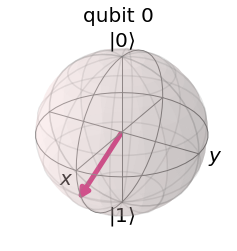

In [93]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

# Создаем состояние Белла в цепи qc, используя кубиты a и b
def create_bell_pair(qc, a, b):
    qc.h(a)    # Перевести кубит q1 a в состояние |+>
    qc.cx(a,b) # CNOT с q1 в качестве ведущего и q2 в качестве ведомого

# Функция, реализующая применение операторов Алисой
# qc - цепь, psi - первый кубит Алисы, а - второй кубит Алисы
def alice_gates(qc, psi, a):
    qc.cx(psi, a)  # Применяем CNOT
    qc.h(psi)      # Применяем оператор Адамара

# Функция измеряет первый и второй кубиты Алисы и "отправляет" их Бобу
def measure_and_send(qc, q0, q1):
    qc.barrier()      # Используем барьер для визуального разделения
    qc.measure(q0,0)  # Измерим первый кубит и запишем результат в первый классический бит
    qc.measure(q1,1)  # Измерим второй кубит и запишем результат во второй  классический бит

# Эта функция принимает квантовую цепь (qc), кубит (qubit)
# и классические регистры (crz и crx) чтобы определить, какие операторы применять
def bob_gates(qc, qubit, crz, crx):
    # Здесь мы используем c_if для управления нашими операторами с помощью классического
    # бита вместо кубита
    qc.x(qubit).c_if(crx, 1) # Применяем оператор к кубиту q2, если
    qc.z(qubit).c_if(crz, 1) # бит находится в состоянии '1'


# Создать случайное однокубитовое состояние  (для инициализации первого кубита Алисы)
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle =")) # Отображение его амплитуд вероятностей (комплексные числа)
plot_bloch_multivector(psi) # Нарисовать сферу Блоха

In [94]:
## НАСТРОЙКА

# Создаем операции инициализации и деинициализации
init_gate = Initialize(psi) 
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute()

## Шаг 1. Инициализация регистров и цепи
qr = QuantumRegister(3, name="q")   # Протокол использует 3 кубита
crz = ClassicalRegister(1, name="crz") # и 2 классических регистра
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

# Добавления операции инициализации первого кубита
qc.append(init_gate, [0])
qc.barrier()

create_bell_pair(qc, 1, 2) # создаем состояние Белла
qc.barrier()

## Шаг 2. Алиса применяет операторы и проводит измерения
alice_gates(qc, 0, 1)
measure_and_send(qc, 0, 1)

## Шаг 3. Боб применяет необходимые операторы
bob_gates(qc, 2, crz, crx)

# Отображение схемы
qc.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.23925+0.40795j,0.54213+0.69457j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                 
«  q_0: ┤M├─────────────────
«       └╥┘┌─┐              
«  q_1: ─╫─┤M├──────────────
«        ║ └╥┘ ┌───┐  ┌───┐ 
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─
«        ║  ║  └─╥─┘  └─╥─┘ 
«        ║  ║    ║   ┌──╨──┐
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞
«        0  ║ ┌──╨──┐└─────┘
«crx: 1/════╩═╡ 0x1 ╞═══════
«           0 └─────┘

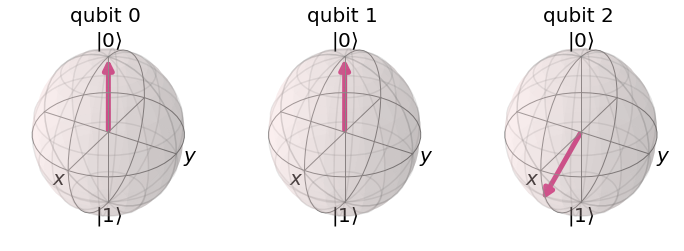

In [95]:
## Запускаем симуляцию и отображение результатов на сфере Блоха

# Копируем схему для второго последующего запуска симуляции
qc1 = qc.copy()

# Запуск симуляции, получение и отображение результатов
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

# Третий кубит имеет точно такую же сферу Блоха, как и первый кубит при инициализации 

In [96]:
## Добавляем обратный процесс инициализации и измерение состояния кубита для второй симуляции

# Обратить процесс инициализации
qc1.append(inverse_init_gate, [2])

# Добавить новый классический регистр, чтобы посмотреть результат
cr_result = ClassicalRegister(1)
qc1.add_register(cr_result)
qc1.measure(2,2)
qc1.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.23925+0.40795j,0.54213+0.69457j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
c24: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                                    
«  q_0: ┤M├────────────────────────────────────
«       └╥┘┌─┐                                 
«  q_1: ─╫─┤M├─────────────────────────────────
«        ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐┌─┐
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├┤M├
«        ║  ║  └─╥─┘  └─╥─┘ └──────────────┘└╥┘
«        ║  ║    ║   ┌──╨──┐                 ║ 
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞═════════════════╬═
«        0  ║ ┌──╨──┐└─────┘                 ║ 
«crx: 1/════╩═╡ 0x1 ╞════════════════════════╬═
«           0 └─────┘                        ║ 
«c24: 1/═════════════════════════════════════╩═
«                                            0

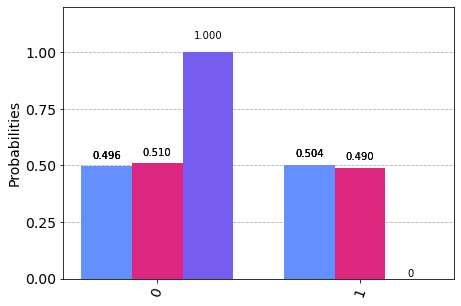

In [97]:
# Запуск симуляции, получение и отображение результатов в виде гистрограммы
t_qc = transpile(qc1, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

# Получаем, что третий кубит находится в состоянии |0> со 100%, т.е. в состоянии,в котором был кубит алисы до инициализации

In [ ]:
class qubit(enum.IntEnum):
    a_0 = 0; a_1 = 1; a_2 = 2
    b_0 = 3; b_1 = 4; b_2 = 5
    out_0 = 6; out_1 = 7; out_2 = 8; out_3 = 9; out_4 = 10; out_5 = 11
    help_0 = 12; help_1 = 13; help_2 = 14; help_3 = 15; help_4 = 16; help_5 = 17

# Цепь суммы
qc_sum = QuantumCircuit(4, name="SUM")
qc_sum.cx(0, 2)
qc_sum.cx(1, 2)
qc_sum.ccx(0, 1, 3)
sum_gate = qc_sum.to_gate()

def multiply(qc: QuantumCircuit):
    qc.ccx(qubit.a_0, qubit.b_0, qubit.out_0)  # a0 & b0 = out1

    qc.ccx(qubit.a_1, qubit.b_0, qubit.help_0) # a1 & b0
    qc.ccx(qubit.a_0, qubit.b_1, qubit.help_1) # a0 & b1
    qc.append(sum_gate, [qubit.help_0, qubit.help_1, qubit.out_1, qubit.help_2]) # a1*b0 + a0*b1
    qc.reset(qubit.help_0); qc.reset(qubit.help_1)

    qc.ccx(qubit.a_2, qubit.b_0, qubit.help_0) # a2 & b0
    qc.ccx(qubit.a_1, qubit.b_1, qubit.help_1) # a1 & b1
    qc.append(sum_gate, [qubit.help_0, qubit.help_1, qubit.help_3, qubit.help_4])
    qc.append(sum_gate, [qubit.help_2, qubit.help_3, qubit.help_5, qubit.help_4])
    qc.reset(qubit.help_0); qc.reset(qubit.help_1)
    qc.reset(qubit.help_2); qc.reset(qubit.help_3)

    qc.ccx(qubit.a_0, qubit.b_2, qubit.help_0)
    qc.append(sum_gate, [qubit.help_5, qubit.help_0, qubit.out_2, qubit.help_1])
    qc.reset(qubit.help_0); qc.reset(qubit.help_5)

    qc.ccx(qubit.a_2, qubit.b_1, qubit.help_0)
    qc.append(sum_gate, [qubit.help_0, qubit.help_4, qubit.help_2, qubit.help_5])
    qc.reset(qubit.help_0); qc.reset(qubit.help_4)

    qc.ccx(qubit.a_1, qubit.b_2, qubit.help_0)
    qc.append(sum_gate, [qubit.help_2, qubit.help_0, qubit.help_3, qubit.help_4])
    qc.append(sum_gate, [qubit.help_3, qubit.help_1, qubit.out_3, qubit.help_4])
    qc.reset(qubit.help_0); qc.reset(qubit.help_1)

    qc.ccx(qubit.a_2, qubit.b_2, qubit.help_0)
    qc.append(sum_gate, [qubit.help_0, qubit.help_5, qubit.help_1, qubit.out_5])
    qc.append(sum_gate, [qubit.help_1, qubit.help_4, qubit.out_4, qubit.out_5])